* WeightFeature has bottle neck -> GAP -> FC -> out
* SVBlock has multi wf, each output * with desired output of every conv block in SVblock
* wf in SVBlock follows Dense concept

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
#         transforms.Lambda(lbp_transform),
#         transforms.Lambda(combine_lbp_hog),
#         transforms.ToPILImage(),
        # transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
#         transforms.RandomRotation(degrees=180),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/train', transform=data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/val', transform=data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/test', transform=data_transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=16)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=16)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=16)

In [4]:
class WeightFeature(nn.Module):

    def __init__(self, feature_depth, target_depth, **kwargs):
        super(WeightFeature, self).__init__()
        self.depths = kwargs['depths'] if 'depths' in kwargs else [256, 128]
        
        self.target_depth = target_depth
        
        self.fc1 = nn.Linear(feature_depth, target_depth)
        
        self.encoder = nn.Sequential(nn.Linear(feature_depth, self.depths[0]),
                                     nn.BatchNorm1d(self.depths[0]), nn.ReLU(True),
                                     nn.Linear(self.depths[0], self.depths[1]),
                                     nn.BatchNorm1d(self.depths[1]), nn.ReLU(True)
                                     )
        
        self.decoder = nn.Sequential(nn.Linear(self.depths[1], self.depths[0]),
                                     nn.BatchNorm1d(self.depths[0]), nn.ReLU(True),
                                     nn.Linear(self.depths[0], target_depth),
                                     nn.BatchNorm1d(target_depth), nn.ReLU()
                                     )
        
        self.bn1 = nn.BatchNorm1d(target_depth)
        self.bn2 = nn.BatchNorm2d(target_depth)
        
    def forward(self, x1):
        '''
        x1 -> GAP -> FC -> sigmoid --> out
        x2 ----------------------------|
        '''
        x1 = nn.AvgPool2d(kernel_size=(x1.size(-2), x1.size(-1)))(x1)
        x1_in = nn.Flatten()(x1)
        
        x1_encode = self.encoder(x1_in)
        x1_decode = self.decoder(x1_encode)
        
        x1 = x1_decode
        x1 = self.bn1(x1)
        x1 = nn.Sigmoid()(x1)
        
        x_out = x1.unsqueeze(-1).unsqueeze(-1)

        return x_out

In [5]:
class WeightFeature(nn.Module):

    def __init__(self, feature_depth, target_depth):
        super(WeightFeature, self).__init__()

        self.target_depth = target_depth
#         self.conv1 = nn.Conv2d(feature_depth, feature_depth, kernel_size=feature_size, padding=0)
#         self.bn = nn.BatchNorm2d(feature_depth)
        self.fc1 = nn.Linear(feature_depth, target_depth)
        self.bn1 = nn.BatchNorm1d(target_depth)
        self.bn2 = nn.BatchNorm2d(target_depth)
        
    def forward(self, x1, x2):
        '''
        x1 -> GAP -> FC -> x2 --> out
        x2 ----------------------------|
        '''
        x1 = nn.AvgPool2d(kernel_size=(x1.size(-2), x1.size(-1)))(x1)
        x1 = nn.Flatten()(x1)

        x1 = self.fc1(x1)
#         x1 = nn.Dropout(0.6)(x1)
        x1 = self.bn1(x1)
        x1 = nn.Softmax()(x1)
#         x1 = nn.ReLU()(x1)
        x1 = x1.unsqueeze(-1).unsqueeze(-1)
        
        x_out = (x1*x2) + x2
        x_out = self.bn2(x_out)
        
        return x_out

In [6]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()
        
        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']
#         self.feature_size = kwargs['feature_size']

        self.index = kwargs['index'] if 'index' in kwargs else None
#         self.depths = kwargs['depths'] if 'depths' in kwargs else [128, 64]
       
        self.identity_conv = nn.Sequential(nn.Conv2d(in_neurons, nb_neurons, kernel_size=1, stride=1, padding=0),
                                           nn.BatchNorm2d(nb_neurons), nn.ReLU(True))
        
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.conv1 = nn.Sequential(nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, stride=1, padding=1),
                                   nn.BatchNorm2d(nb_neurons), nn.ReLU(True))
        
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.preconv2 = nn.Sequential(nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1, stride=1, padding=0),
                                   nn.BatchNorm2d(nb_neurons), nn.ReLU(True))
        self.conv2 = nn.Sequential(nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, stride=1, padding=1),
                                   nn.BatchNorm2d(nb_neurons), nn.ReLU(True))
        
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        self.preconv3 = nn.Sequential(nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1, stride=1, padding=0),
                                   nn.BatchNorm2d(nb_neurons), nn.ReLU(True))
        self.conv3 = nn.Sequential(nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, stride=1, padding=1),
                                   nn.BatchNorm2d(nb_neurons), nn.ReLU(True))
        
        self.conv4 = nn.Sequential(nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, stride=1, padding=1),
                                   nn.BatchNorm2d(nb_neurons), nn.ReLU(True))
        
        self.bnout = nn.BatchNorm2d(nb_neurons)
        self.preconvout = nn.Sequential(nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1, stride=1, padding=0),
                                   nn.BatchNorm2d(nb_neurons), nn.ReLU(True))
        
        self.wf1 = WeightFeature(nb_neurons, nb_neurons)
        self.wf2 = WeightFeature(nb_neurons, nb_neurons)
        self.wf3 = WeightFeature(nb_neurons, nb_neurons)
        
    def forward(self, x):
        '''
        x: single output layer of list 
        '''
        
        x0 = self.identity_conv(x)
        
        x1 = self.conv1(x0)
        
        x2 = self.conv2(x1)
        
        wf12_3 = self.wf1(x1, x2)
        
        x3 = self.conv3(wf12_3)
        
        wf23_4 = self.wf2(x2, x3)
        
        x4 = self.conv4(wf23_4)
        
        x_out = self.wf3(x3, x4)
        
        return x_out

In [7]:
class SVGG(nn.Module):

    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1,64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 1024).to(self.device)

        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x0 = self.sv0(x)
        x0 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x0)
        
        x1 = self.sv1(x0)
        x1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x1)
        
        x2 = self.sv2(x1)
        x2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x2)
        
        x3 = self.sv3(x2)
        x3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x3)
        
        x4 = self.sv4(x3)
        x4 = nn.MaxPool2d(kernel_size=(2,2), stride=2)(x4)
        
        x_out = nn.AvgPool2d(kernel_size=(x4.size(-2), x4.size(-1)))(x4)
        x_out = nn.Flatten()(x_out)

        x_out = self.fc1(x_out)
        x_out = self.bn1(x_out)
        x_out = self.fc2(x_out)
        x_out = self.bn2(x_out)

        return x_out


In [8]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# model.train()

# model = model.to(device)

cuda


In [9]:
model = model.to(device)

model_path = '/tf/data/Quan/fer2013/att_vgg_ae_models/model1.pt'
best_acc = 0.0
hist = []

for epoch in range(60):  # loop over the dataset multiple times
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
       
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
        print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

Epoch:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


	 - Step 1: loss: 2.287 acc: 0.148
	 - Step 2: loss: 2.177 acc: 0.141
	 - Step 3: loss: 2.086 acc: 0.195
	 - Step 4: loss: 2.223 acc: 0.227
	 - Step 5: loss: 2.078 acc: 0.148
	 - Step 6: loss: 2.125 acc: 0.305
	 - Step 7: loss: 2.111 acc: 0.203
	 - Step 8: loss: 1.962 acc: 0.219
	 - Step 9: loss: 2.138 acc: 0.227
	 - Step 10: loss: 2.111 acc: 0.281
	 - Step 11: loss: 2.174 acc: 0.219
	 - Step 12: loss: 1.896 acc: 0.266
	 - Step 13: loss: 1.931 acc: 0.219
	 - Step 14: loss: 1.918 acc: 0.242
	 - Step 15: loss: 2.028 acc: 0.258
	 - Step 16: loss: 1.917 acc: 0.273
	 - Step 17: loss: 2.166 acc: 0.172
	 - Step 18: loss: 2.068 acc: 0.188
	 - Step 19: loss: 1.893 acc: 0.242
	 - Step 20: loss: 2.080 acc: 0.305
	 - Step 21: loss: 2.080 acc: 0.211
	 - Step 22: loss: 2.068 acc: 0.219
	 - Step 23: loss: 1.887 acc: 0.203
	 - Step 24: loss: 1.904 acc: 0.172
	 - Step 25: loss: 2.102 acc: 0.203
	 - Step 26: loss: 2.084 acc: 0.195
	 - Step 27: loss: 2.095 acc: 0.234
	 - Step 28: loss: 2.081 acc: 0.195
	

- Avg.loss: 1.906  | Avg.acc: 0.239
- Avg. val_loss: 1.838  | Avg. val_acc: 0.248


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WeightFeature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


* Update optimal model
Epoch:  2
	 - Step 1: loss: 1.851 acc: 0.227
	 - Step 2: loss: 1.818 acc: 0.250
	 - Step 3: loss: 1.852 acc: 0.258
	 - Step 4: loss: 1.830 acc: 0.219
	 - Step 5: loss: 1.766 acc: 0.219
	 - Step 6: loss: 1.776 acc: 0.273
	 - Step 7: loss: 1.852 acc: 0.258
	 - Step 8: loss: 1.796 acc: 0.281
	 - Step 9: loss: 1.773 acc: 0.289
	 - Step 10: loss: 1.776 acc: 0.258
	 - Step 11: loss: 1.756 acc: 0.305
	 - Step 12: loss: 1.743 acc: 0.297
	 - Step 13: loss: 1.871 acc: 0.195
	 - Step 14: loss: 1.854 acc: 0.211
	 - Step 15: loss: 1.791 acc: 0.250
	 - Step 16: loss: 1.892 acc: 0.242
	 - Step 17: loss: 1.798 acc: 0.305
	 - Step 18: loss: 1.783 acc: 0.266
	 - Step 19: loss: 1.857 acc: 0.148
	 - Step 20: loss: 1.775 acc: 0.320
	 - Step 21: loss: 1.753 acc: 0.328
	 - Step 22: loss: 1.791 acc: 0.266
	 - Step 23: loss: 1.805 acc: 0.266
	 - Step 24: loss: 1.766 acc: 0.297
	 - Step 25: loss: 1.764 acc: 0.227
	 - Step 26: loss: 1.750 acc: 0.266
	 - Step 27: loss: 1.790 acc: 0.266
	 - 

- Avg.loss: 1.756  | Avg.acc: 0.283
- Avg. val_loss: 1.737  | Avg. val_acc: 0.246
Epoch:  3
	 - Step 1: loss: 1.699 acc: 0.344
	 - Step 2: loss: 1.605 acc: 0.391
	 - Step 3: loss: 1.637 acc: 0.367
	 - Step 4: loss: 1.654 acc: 0.320
	 - Step 5: loss: 1.571 acc: 0.383
	 - Step 6: loss: 1.657 acc: 0.305
	 - Step 7: loss: 1.535 acc: 0.375
	 - Step 8: loss: 1.737 acc: 0.297
	 - Step 9: loss: 1.689 acc: 0.297
	 - Step 10: loss: 1.679 acc: 0.336
	 - Step 11: loss: 1.654 acc: 0.312
	 - Step 12: loss: 1.640 acc: 0.305
	 - Step 13: loss: 1.598 acc: 0.312
	 - Step 14: loss: 1.655 acc: 0.375
	 - Step 15: loss: 1.635 acc: 0.305
	 - Step 16: loss: 1.737 acc: 0.305
	 - Step 17: loss: 1.637 acc: 0.344
	 - Step 18: loss: 1.654 acc: 0.336
	 - Step 19: loss: 1.649 acc: 0.352
	 - Step 20: loss: 1.725 acc: 0.344
	 - Step 21: loss: 1.753 acc: 0.281
	 - Step 22: loss: 1.762 acc: 0.219
	 - Step 23: loss: 1.689 acc: 0.250
	 - Step 24: loss: 1.577 acc: 0.359
	 - Step 25: loss: 1.652 acc: 0.312
	 - Step 26: loss

	 - Step 113: loss: 1.379 acc: 0.461
	 - Step 114: loss: 1.357 acc: 0.500
	 - Step 115: loss: 1.390 acc: 0.469
	 - Step 116: loss: 1.412 acc: 0.438
	 - Step 117: loss: 1.385 acc: 0.445
	 - Step 118: loss: 1.356 acc: 0.391
	 - Step 119: loss: 1.422 acc: 0.391
	 - Step 120: loss: 1.381 acc: 0.422
	 - Step 121: loss: 1.394 acc: 0.414
	 - Step 122: loss: 1.387 acc: 0.391
	 - Step 123: loss: 1.376 acc: 0.430
	 - Step 124: loss: 1.510 acc: 0.367
	 - Step 125: loss: 1.454 acc: 0.438
	 - Step 126: loss: 1.534 acc: 0.336
	 - Step 127: loss: 1.278 acc: 0.445
	 - Step 128: loss: 1.291 acc: 0.461
	 - Step 129: loss: 1.401 acc: 0.398
	 - Step 130: loss: 1.280 acc: 0.445
	 - Step 131: loss: 1.339 acc: 0.422
	 - Step 132: loss: 1.405 acc: 0.422
	 - Step 133: loss: 1.399 acc: 0.375
	 - Step 134: loss: 1.459 acc: 0.383
	 - Step 135: loss: 1.301 acc: 0.484
	 - Step 136: loss: 1.319 acc: 0.469
	 - Step 137: loss: 1.306 acc: 0.547
	 - Step 138: loss: 1.443 acc: 0.391
	 - Step 139: loss: 1.440 acc: 0.398
	

	 - Step 110: loss: 1.272 acc: 0.508
	 - Step 111: loss: 1.142 acc: 0.508
	 - Step 112: loss: 1.355 acc: 0.484
	 - Step 113: loss: 1.405 acc: 0.438
	 - Step 114: loss: 1.388 acc: 0.414
	 - Step 115: loss: 1.249 acc: 0.586
	 - Step 116: loss: 1.414 acc: 0.445
	 - Step 117: loss: 1.243 acc: 0.500
	 - Step 118: loss: 1.452 acc: 0.477
	 - Step 119: loss: 1.428 acc: 0.430
	 - Step 120: loss: 1.416 acc: 0.492
	 - Step 121: loss: 1.303 acc: 0.469
	 - Step 122: loss: 1.463 acc: 0.430
	 - Step 123: loss: 1.362 acc: 0.484
	 - Step 124: loss: 1.415 acc: 0.430
	 - Step 125: loss: 1.412 acc: 0.414
	 - Step 126: loss: 1.453 acc: 0.406
	 - Step 127: loss: 1.462 acc: 0.375
	 - Step 128: loss: 1.282 acc: 0.508
	 - Step 129: loss: 1.421 acc: 0.438
	 - Step 130: loss: 1.272 acc: 0.453
	 - Step 131: loss: 1.289 acc: 0.469
	 - Step 132: loss: 1.320 acc: 0.469
	 - Step 133: loss: 1.376 acc: 0.438
	 - Step 134: loss: 1.333 acc: 0.461
	 - Step 135: loss: 1.313 acc: 0.438
	 - Step 136: loss: 1.397 acc: 0.438
	

	 - Step 107: loss: 1.347 acc: 0.516
	 - Step 108: loss: 1.428 acc: 0.422
	 - Step 109: loss: 1.268 acc: 0.477
	 - Step 110: loss: 1.289 acc: 0.477
	 - Step 111: loss: 1.246 acc: 0.445
	 - Step 112: loss: 1.373 acc: 0.445
	 - Step 113: loss: 1.394 acc: 0.461
	 - Step 114: loss: 1.264 acc: 0.508
	 - Step 115: loss: 1.446 acc: 0.344
	 - Step 116: loss: 1.335 acc: 0.461
	 - Step 117: loss: 1.391 acc: 0.453
	 - Step 118: loss: 1.389 acc: 0.438
	 - Step 119: loss: 1.322 acc: 0.453
	 - Step 120: loss: 1.266 acc: 0.477
	 - Step 121: loss: 1.344 acc: 0.445
	 - Step 122: loss: 1.297 acc: 0.469
	 - Step 123: loss: 1.241 acc: 0.492
	 - Step 124: loss: 1.328 acc: 0.477
	 - Step 125: loss: 1.196 acc: 0.570
	 - Step 126: loss: 1.349 acc: 0.469
	 - Step 127: loss: 1.406 acc: 0.445
	 - Step 128: loss: 1.299 acc: 0.500
	 - Step 129: loss: 1.195 acc: 0.547
	 - Step 130: loss: 1.339 acc: 0.484
	 - Step 131: loss: 1.286 acc: 0.461
	 - Step 132: loss: 1.414 acc: 0.453
	 - Step 133: loss: 1.355 acc: 0.492
	

	 - Step 104: loss: 1.291 acc: 0.445
	 - Step 105: loss: 1.353 acc: 0.438
	 - Step 106: loss: 1.354 acc: 0.445
	 - Step 107: loss: 1.270 acc: 0.469
	 - Step 108: loss: 1.289 acc: 0.438
	 - Step 109: loss: 1.387 acc: 0.477
	 - Step 110: loss: 1.212 acc: 0.531
	 - Step 111: loss: 1.294 acc: 0.477
	 - Step 112: loss: 1.265 acc: 0.500
	 - Step 113: loss: 1.200 acc: 0.516
	 - Step 114: loss: 1.236 acc: 0.516
	 - Step 115: loss: 1.270 acc: 0.516
	 - Step 116: loss: 1.266 acc: 0.508
	 - Step 117: loss: 1.176 acc: 0.531
	 - Step 118: loss: 1.289 acc: 0.500
	 - Step 119: loss: 1.350 acc: 0.469
	 - Step 120: loss: 1.463 acc: 0.367
	 - Step 121: loss: 1.200 acc: 0.555
	 - Step 122: loss: 1.172 acc: 0.531
	 - Step 123: loss: 1.448 acc: 0.406
	 - Step 124: loss: 1.367 acc: 0.445
	 - Step 125: loss: 1.242 acc: 0.547
	 - Step 126: loss: 1.440 acc: 0.445
	 - Step 127: loss: 1.337 acc: 0.469
	 - Step 128: loss: 1.263 acc: 0.469
	 - Step 129: loss: 1.285 acc: 0.438
	 - Step 130: loss: 1.303 acc: 0.508
	

	 - Step 101: loss: 1.347 acc: 0.469
	 - Step 102: loss: 1.368 acc: 0.406
	 - Step 103: loss: 1.218 acc: 0.523
	 - Step 104: loss: 1.163 acc: 0.516
	 - Step 105: loss: 1.402 acc: 0.469
	 - Step 106: loss: 1.179 acc: 0.555
	 - Step 107: loss: 1.203 acc: 0.500
	 - Step 108: loss: 1.188 acc: 0.539
	 - Step 109: loss: 1.283 acc: 0.492
	 - Step 110: loss: 1.200 acc: 0.539
	 - Step 111: loss: 1.273 acc: 0.516
	 - Step 112: loss: 1.184 acc: 0.516
	 - Step 113: loss: 1.090 acc: 0.531
	 - Step 114: loss: 1.180 acc: 0.547
	 - Step 115: loss: 1.351 acc: 0.469
	 - Step 116: loss: 1.271 acc: 0.492
	 - Step 117: loss: 1.238 acc: 0.547
	 - Step 118: loss: 1.134 acc: 0.539
	 - Step 119: loss: 1.269 acc: 0.492
	 - Step 120: loss: 1.185 acc: 0.500
	 - Step 121: loss: 1.147 acc: 0.570
	 - Step 122: loss: 1.296 acc: 0.453
	 - Step 123: loss: 1.242 acc: 0.539
	 - Step 124: loss: 1.245 acc: 0.477
	 - Step 125: loss: 1.221 acc: 0.516
	 - Step 126: loss: 1.195 acc: 0.531
	 - Step 127: loss: 1.268 acc: 0.539
	

	 - Step 98: loss: 1.376 acc: 0.477
	 - Step 99: loss: 1.450 acc: 0.469
	 - Step 100: loss: 1.245 acc: 0.500
	 - Step 101: loss: 1.275 acc: 0.539
	 - Step 102: loss: 1.354 acc: 0.422
	 - Step 103: loss: 1.247 acc: 0.492
	 - Step 104: loss: 1.307 acc: 0.484
	 - Step 105: loss: 1.403 acc: 0.445
	 - Step 106: loss: 1.158 acc: 0.594
	 - Step 107: loss: 1.220 acc: 0.508
	 - Step 108: loss: 1.097 acc: 0.617
	 - Step 109: loss: 1.274 acc: 0.484
	 - Step 110: loss: 1.310 acc: 0.547
	 - Step 111: loss: 1.353 acc: 0.508
	 - Step 112: loss: 1.320 acc: 0.516
	 - Step 113: loss: 1.214 acc: 0.500
	 - Step 114: loss: 1.198 acc: 0.445
	 - Step 115: loss: 1.128 acc: 0.531
	 - Step 116: loss: 1.166 acc: 0.508
	 - Step 117: loss: 1.272 acc: 0.516
	 - Step 118: loss: 1.203 acc: 0.531
	 - Step 119: loss: 1.250 acc: 0.555
	 - Step 120: loss: 1.257 acc: 0.500
	 - Step 121: loss: 1.187 acc: 0.492
	 - Step 122: loss: 1.241 acc: 0.500
	 - Step 123: loss: 1.398 acc: 0.430
	 - Step 124: loss: 1.327 acc: 0.484
	 -

	 - Step 95: loss: 1.190 acc: 0.562
	 - Step 96: loss: 1.056 acc: 0.586
	 - Step 97: loss: 1.096 acc: 0.578
	 - Step 98: loss: 1.389 acc: 0.500
	 - Step 99: loss: 1.310 acc: 0.445
	 - Step 100: loss: 1.107 acc: 0.555
	 - Step 101: loss: 1.314 acc: 0.477
	 - Step 102: loss: 1.119 acc: 0.617
	 - Step 103: loss: 1.186 acc: 0.523
	 - Step 104: loss: 1.184 acc: 0.570
	 - Step 105: loss: 1.156 acc: 0.516
	 - Step 106: loss: 1.217 acc: 0.430
	 - Step 107: loss: 1.260 acc: 0.453
	 - Step 108: loss: 1.276 acc: 0.453
	 - Step 109: loss: 1.173 acc: 0.570
	 - Step 110: loss: 1.215 acc: 0.516
	 - Step 111: loss: 1.234 acc: 0.484
	 - Step 112: loss: 1.326 acc: 0.516
	 - Step 113: loss: 1.171 acc: 0.555
	 - Step 114: loss: 1.275 acc: 0.477
	 - Step 115: loss: 1.327 acc: 0.430
	 - Step 116: loss: 1.215 acc: 0.523
	 - Step 117: loss: 1.173 acc: 0.508
	 - Step 118: loss: 1.267 acc: 0.477
	 - Step 119: loss: 1.365 acc: 0.477
	 - Step 120: loss: 1.375 acc: 0.477
	 - Step 121: loss: 1.193 acc: 0.484
	 - St

	 - Step 92: loss: 1.156 acc: 0.547
	 - Step 93: loss: 1.062 acc: 0.578
	 - Step 94: loss: 1.132 acc: 0.539
	 - Step 95: loss: 1.360 acc: 0.469
	 - Step 96: loss: 1.166 acc: 0.508
	 - Step 97: loss: 1.312 acc: 0.531
	 - Step 98: loss: 1.343 acc: 0.453
	 - Step 99: loss: 1.282 acc: 0.547
	 - Step 100: loss: 1.260 acc: 0.469
	 - Step 101: loss: 1.354 acc: 0.422
	 - Step 102: loss: 1.233 acc: 0.500
	 - Step 103: loss: 1.147 acc: 0.547
	 - Step 104: loss: 1.168 acc: 0.586
	 - Step 105: loss: 1.367 acc: 0.477
	 - Step 106: loss: 1.260 acc: 0.484
	 - Step 107: loss: 1.214 acc: 0.484
	 - Step 108: loss: 1.283 acc: 0.461
	 - Step 109: loss: 1.168 acc: 0.539
	 - Step 110: loss: 1.383 acc: 0.406
	 - Step 111: loss: 1.157 acc: 0.516
	 - Step 112: loss: 1.141 acc: 0.586
	 - Step 113: loss: 1.309 acc: 0.453
	 - Step 114: loss: 1.289 acc: 0.523
	 - Step 115: loss: 1.145 acc: 0.516
	 - Step 116: loss: 1.241 acc: 0.484
	 - Step 117: loss: 1.219 acc: 0.578
	 - Step 118: loss: 1.244 acc: 0.562
	 - Step 

	 - Step 89: loss: 1.393 acc: 0.430
	 - Step 90: loss: 1.183 acc: 0.516
	 - Step 91: loss: 1.223 acc: 0.594
	 - Step 92: loss: 1.527 acc: 0.406
	 - Step 93: loss: 1.229 acc: 0.578
	 - Step 94: loss: 1.249 acc: 0.461
	 - Step 95: loss: 1.323 acc: 0.500
	 - Step 96: loss: 1.083 acc: 0.586
	 - Step 97: loss: 1.074 acc: 0.586
	 - Step 98: loss: 1.190 acc: 0.586
	 - Step 99: loss: 1.100 acc: 0.586
	 - Step 100: loss: 1.225 acc: 0.492
	 - Step 101: loss: 1.323 acc: 0.461
	 - Step 102: loss: 1.263 acc: 0.508
	 - Step 103: loss: 1.252 acc: 0.531
	 - Step 104: loss: 1.054 acc: 0.625
	 - Step 105: loss: 1.253 acc: 0.516
	 - Step 106: loss: 1.106 acc: 0.609
	 - Step 107: loss: 1.030 acc: 0.672
	 - Step 108: loss: 1.215 acc: 0.570
	 - Step 109: loss: 1.168 acc: 0.531
	 - Step 110: loss: 1.131 acc: 0.570
	 - Step 111: loss: 1.210 acc: 0.508
	 - Step 112: loss: 1.244 acc: 0.492
	 - Step 113: loss: 1.132 acc: 0.516
	 - Step 114: loss: 1.300 acc: 0.453
	 - Step 115: loss: 1.241 acc: 0.547
	 - Step 116

	 - Step 86: loss: 1.210 acc: 0.477
	 - Step 87: loss: 1.304 acc: 0.500
	 - Step 88: loss: 1.262 acc: 0.523
	 - Step 89: loss: 1.202 acc: 0.516
	 - Step 90: loss: 1.175 acc: 0.500
	 - Step 91: loss: 1.247 acc: 0.531
	 - Step 92: loss: 1.234 acc: 0.531
	 - Step 93: loss: 1.278 acc: 0.523
	 - Step 94: loss: 1.280 acc: 0.453
	 - Step 95: loss: 1.279 acc: 0.539
	 - Step 96: loss: 1.314 acc: 0.461
	 - Step 97: loss: 1.170 acc: 0.578
	 - Step 98: loss: 1.268 acc: 0.516
	 - Step 99: loss: 1.334 acc: 0.508
	 - Step 100: loss: 1.173 acc: 0.555
	 - Step 101: loss: 1.065 acc: 0.602
	 - Step 102: loss: 1.464 acc: 0.398
	 - Step 103: loss: 1.138 acc: 0.562
	 - Step 104: loss: 1.254 acc: 0.562
	 - Step 105: loss: 1.221 acc: 0.555
	 - Step 106: loss: 1.313 acc: 0.477
	 - Step 107: loss: 1.238 acc: 0.555
	 - Step 108: loss: 1.018 acc: 0.625
	 - Step 109: loss: 1.166 acc: 0.602
	 - Step 110: loss: 1.334 acc: 0.461
	 - Step 111: loss: 1.157 acc: 0.594
	 - Step 112: loss: 1.012 acc: 0.680
	 - Step 113: l

	 - Step 83: loss: 1.118 acc: 0.570
	 - Step 84: loss: 1.146 acc: 0.539
	 - Step 85: loss: 1.357 acc: 0.484
	 - Step 86: loss: 1.244 acc: 0.523
	 - Step 87: loss: 1.150 acc: 0.555
	 - Step 88: loss: 1.160 acc: 0.461
	 - Step 89: loss: 1.126 acc: 0.539
	 - Step 90: loss: 1.286 acc: 0.531
	 - Step 91: loss: 1.195 acc: 0.500
	 - Step 92: loss: 1.136 acc: 0.562
	 - Step 93: loss: 1.158 acc: 0.539
	 - Step 94: loss: 1.075 acc: 0.539
	 - Step 95: loss: 1.268 acc: 0.477
	 - Step 96: loss: 1.231 acc: 0.531
	 - Step 97: loss: 1.306 acc: 0.500
	 - Step 98: loss: 1.166 acc: 0.555
	 - Step 99: loss: 1.263 acc: 0.477
	 - Step 100: loss: 1.489 acc: 0.477
	 - Step 101: loss: 1.231 acc: 0.508
	 - Step 102: loss: 1.160 acc: 0.562
	 - Step 103: loss: 1.194 acc: 0.539
	 - Step 104: loss: 1.151 acc: 0.570
	 - Step 105: loss: 1.074 acc: 0.625
	 - Step 106: loss: 1.233 acc: 0.492
	 - Step 107: loss: 1.296 acc: 0.453
	 - Step 108: loss: 1.169 acc: 0.555
	 - Step 109: loss: 1.299 acc: 0.461
	 - Step 110: loss

	 - Step 80: loss: 1.285 acc: 0.516
	 - Step 81: loss: 1.175 acc: 0.594
	 - Step 82: loss: 1.105 acc: 0.578
	 - Step 83: loss: 1.143 acc: 0.562
	 - Step 84: loss: 1.176 acc: 0.602
	 - Step 85: loss: 1.118 acc: 0.570
	 - Step 86: loss: 1.087 acc: 0.594
	 - Step 87: loss: 1.111 acc: 0.539
	 - Step 88: loss: 1.174 acc: 0.523
	 - Step 89: loss: 1.150 acc: 0.555
	 - Step 90: loss: 1.190 acc: 0.531
	 - Step 91: loss: 1.065 acc: 0.562
	 - Step 92: loss: 1.222 acc: 0.555
	 - Step 93: loss: 1.144 acc: 0.547
	 - Step 94: loss: 1.038 acc: 0.594
	 - Step 95: loss: 1.240 acc: 0.516
	 - Step 96: loss: 1.234 acc: 0.523
	 - Step 97: loss: 1.152 acc: 0.555
	 - Step 98: loss: 1.166 acc: 0.570
	 - Step 99: loss: 1.048 acc: 0.602
	 - Step 100: loss: 1.086 acc: 0.602
	 - Step 101: loss: 1.134 acc: 0.594
	 - Step 102: loss: 1.249 acc: 0.461
	 - Step 103: loss: 1.144 acc: 0.531
	 - Step 104: loss: 1.267 acc: 0.586
	 - Step 105: loss: 1.030 acc: 0.641
	 - Step 106: loss: 1.050 acc: 0.648
	 - Step 107: loss: 1

	 - Step 77: loss: 1.116 acc: 0.562
	 - Step 78: loss: 1.292 acc: 0.547
	 - Step 79: loss: 1.240 acc: 0.562
	 - Step 80: loss: 1.290 acc: 0.469
	 - Step 81: loss: 1.150 acc: 0.555
	 - Step 82: loss: 1.266 acc: 0.461
	 - Step 83: loss: 1.075 acc: 0.602
	 - Step 84: loss: 1.104 acc: 0.562
	 - Step 85: loss: 1.376 acc: 0.523
	 - Step 86: loss: 1.180 acc: 0.594
	 - Step 87: loss: 1.205 acc: 0.516
	 - Step 88: loss: 1.156 acc: 0.492
	 - Step 89: loss: 1.222 acc: 0.516
	 - Step 90: loss: 1.214 acc: 0.539
	 - Step 91: loss: 1.345 acc: 0.406
	 - Step 92: loss: 1.227 acc: 0.516
	 - Step 93: loss: 1.162 acc: 0.539
	 - Step 94: loss: 1.403 acc: 0.438
	 - Step 95: loss: 1.108 acc: 0.586
	 - Step 96: loss: 1.196 acc: 0.555
	 - Step 97: loss: 1.246 acc: 0.555
	 - Step 98: loss: 1.135 acc: 0.547
	 - Step 99: loss: 1.106 acc: 0.578
	 - Step 100: loss: 1.104 acc: 0.578
	 - Step 101: loss: 1.295 acc: 0.492
	 - Step 102: loss: 1.212 acc: 0.547
	 - Step 103: loss: 1.194 acc: 0.539
	 - Step 104: loss: 1.09

	 - Step 74: loss: 1.425 acc: 0.445
	 - Step 75: loss: 1.214 acc: 0.531
	 - Step 76: loss: 1.303 acc: 0.508
	 - Step 77: loss: 1.154 acc: 0.539
	 - Step 78: loss: 1.144 acc: 0.570
	 - Step 79: loss: 1.214 acc: 0.508
	 - Step 80: loss: 1.091 acc: 0.578
	 - Step 81: loss: 1.306 acc: 0.492
	 - Step 82: loss: 1.083 acc: 0.625
	 - Step 83: loss: 1.244 acc: 0.562
	 - Step 84: loss: 1.088 acc: 0.578
	 - Step 85: loss: 1.335 acc: 0.469
	 - Step 86: loss: 1.337 acc: 0.445
	 - Step 87: loss: 1.257 acc: 0.539
	 - Step 88: loss: 1.296 acc: 0.523
	 - Step 89: loss: 1.207 acc: 0.539
	 - Step 90: loss: 1.050 acc: 0.625
	 - Step 91: loss: 1.021 acc: 0.578
	 - Step 92: loss: 1.347 acc: 0.453
	 - Step 93: loss: 1.260 acc: 0.523
	 - Step 94: loss: 1.162 acc: 0.562
	 - Step 95: loss: 1.154 acc: 0.555
	 - Step 96: loss: 1.072 acc: 0.586
	 - Step 97: loss: 1.193 acc: 0.477
	 - Step 98: loss: 1.198 acc: 0.523
	 - Step 99: loss: 1.132 acc: 0.500
	 - Step 100: loss: 1.123 acc: 0.609
	 - Step 101: loss: 1.294 a

	 - Step 71: loss: 1.263 acc: 0.500
	 - Step 72: loss: 1.144 acc: 0.484
	 - Step 73: loss: 1.132 acc: 0.547
	 - Step 74: loss: 1.246 acc: 0.523
	 - Step 75: loss: 1.224 acc: 0.523
	 - Step 76: loss: 1.074 acc: 0.625
	 - Step 77: loss: 1.329 acc: 0.539
	 - Step 78: loss: 1.141 acc: 0.523
	 - Step 79: loss: 1.219 acc: 0.539
	 - Step 80: loss: 1.277 acc: 0.469
	 - Step 81: loss: 1.112 acc: 0.539
	 - Step 82: loss: 1.189 acc: 0.547
	 - Step 83: loss: 1.232 acc: 0.602
	 - Step 84: loss: 1.253 acc: 0.469
	 - Step 85: loss: 1.280 acc: 0.484
	 - Step 86: loss: 1.051 acc: 0.586
	 - Step 87: loss: 1.208 acc: 0.531
	 - Step 88: loss: 1.366 acc: 0.492
	 - Step 89: loss: 1.184 acc: 0.555
	 - Step 90: loss: 1.137 acc: 0.617
	 - Step 91: loss: 1.162 acc: 0.562
	 - Step 92: loss: 1.204 acc: 0.562
	 - Step 93: loss: 1.196 acc: 0.539
	 - Step 94: loss: 1.224 acc: 0.492
	 - Step 95: loss: 1.156 acc: 0.523
	 - Step 96: loss: 1.062 acc: 0.547
	 - Step 97: loss: 1.256 acc: 0.547
	 - Step 98: loss: 1.134 acc

	 - Step 68: loss: 1.073 acc: 0.586
	 - Step 69: loss: 1.127 acc: 0.555
	 - Step 70: loss: 1.183 acc: 0.547
	 - Step 71: loss: 1.013 acc: 0.570
	 - Step 72: loss: 1.215 acc: 0.523
	 - Step 73: loss: 1.220 acc: 0.461
	 - Step 74: loss: 1.223 acc: 0.500
	 - Step 75: loss: 1.269 acc: 0.461
	 - Step 76: loss: 1.245 acc: 0.453
	 - Step 77: loss: 1.135 acc: 0.539
	 - Step 78: loss: 1.224 acc: 0.523
	 - Step 79: loss: 1.116 acc: 0.602
	 - Step 80: loss: 1.068 acc: 0.586
	 - Step 81: loss: 1.007 acc: 0.586
	 - Step 82: loss: 1.283 acc: 0.586
	 - Step 83: loss: 1.129 acc: 0.555
	 - Step 84: loss: 1.177 acc: 0.500
	 - Step 85: loss: 1.215 acc: 0.523
	 - Step 86: loss: 1.269 acc: 0.492
	 - Step 87: loss: 1.209 acc: 0.500
	 - Step 88: loss: 1.197 acc: 0.484
	 - Step 89: loss: 1.169 acc: 0.555
	 - Step 90: loss: 1.127 acc: 0.523
	 - Step 91: loss: 1.180 acc: 0.547
	 - Step 92: loss: 1.172 acc: 0.539
	 - Step 93: loss: 1.112 acc: 0.539
	 - Step 94: loss: 1.079 acc: 0.523
	 - Step 95: loss: 1.223 acc

	 - Step 65: loss: 1.245 acc: 0.531
	 - Step 66: loss: 1.099 acc: 0.547
	 - Step 67: loss: 1.084 acc: 0.578
	 - Step 68: loss: 1.059 acc: 0.602
	 - Step 69: loss: 1.191 acc: 0.523
	 - Step 70: loss: 1.120 acc: 0.602
	 - Step 71: loss: 1.393 acc: 0.508
	 - Step 72: loss: 1.255 acc: 0.523
	 - Step 73: loss: 1.223 acc: 0.500
	 - Step 74: loss: 1.186 acc: 0.500
	 - Step 75: loss: 1.291 acc: 0.500
	 - Step 76: loss: 1.160 acc: 0.586
	 - Step 77: loss: 1.115 acc: 0.609
	 - Step 78: loss: 1.105 acc: 0.555
	 - Step 79: loss: 1.225 acc: 0.531
	 - Step 80: loss: 1.301 acc: 0.531
	 - Step 81: loss: 1.260 acc: 0.508
	 - Step 82: loss: 1.065 acc: 0.547
	 - Step 83: loss: 1.130 acc: 0.570
	 - Step 84: loss: 1.216 acc: 0.539
	 - Step 85: loss: 1.126 acc: 0.625
	 - Step 86: loss: 1.091 acc: 0.602
	 - Step 87: loss: 1.139 acc: 0.531
	 - Step 88: loss: 1.175 acc: 0.547
	 - Step 89: loss: 1.136 acc: 0.539
	 - Step 90: loss: 1.160 acc: 0.555
	 - Step 91: loss: 1.243 acc: 0.531
	 - Step 92: loss: 1.225 acc

	 - Step 62: loss: 1.129 acc: 0.562
	 - Step 63: loss: 1.152 acc: 0.555
	 - Step 64: loss: 1.144 acc: 0.547
	 - Step 65: loss: 1.227 acc: 0.523
	 - Step 66: loss: 1.002 acc: 0.625
	 - Step 67: loss: 1.184 acc: 0.523
	 - Step 68: loss: 1.124 acc: 0.555
	 - Step 69: loss: 1.155 acc: 0.578
	 - Step 70: loss: 1.209 acc: 0.547
	 - Step 71: loss: 1.195 acc: 0.555
	 - Step 72: loss: 1.228 acc: 0.531
	 - Step 73: loss: 1.174 acc: 0.547
	 - Step 74: loss: 1.052 acc: 0.578
	 - Step 75: loss: 1.126 acc: 0.523
	 - Step 76: loss: 1.254 acc: 0.547
	 - Step 77: loss: 1.141 acc: 0.562
	 - Step 78: loss: 1.287 acc: 0.516
	 - Step 79: loss: 1.132 acc: 0.570
	 - Step 80: loss: 1.362 acc: 0.453
	 - Step 81: loss: 1.243 acc: 0.492
	 - Step 82: loss: 1.138 acc: 0.531
	 - Step 83: loss: 1.043 acc: 0.555
	 - Step 84: loss: 1.310 acc: 0.516
	 - Step 85: loss: 1.013 acc: 0.617
	 - Step 86: loss: 1.154 acc: 0.547
	 - Step 87: loss: 1.274 acc: 0.477
	 - Step 88: loss: 1.171 acc: 0.508
	 - Step 89: loss: 1.209 acc

	 - Step 59: loss: 1.053 acc: 0.609
	 - Step 60: loss: 1.190 acc: 0.555
	 - Step 61: loss: 1.273 acc: 0.539
	 - Step 62: loss: 1.104 acc: 0.578
	 - Step 63: loss: 1.110 acc: 0.555
	 - Step 64: loss: 1.188 acc: 0.531
	 - Step 65: loss: 1.095 acc: 0.539
	 - Step 66: loss: 1.169 acc: 0.500
	 - Step 67: loss: 1.148 acc: 0.516
	 - Step 68: loss: 1.240 acc: 0.555
	 - Step 69: loss: 1.183 acc: 0.555
	 - Step 70: loss: 1.227 acc: 0.547
	 - Step 71: loss: 1.036 acc: 0.555
	 - Step 72: loss: 1.125 acc: 0.555
	 - Step 73: loss: 1.141 acc: 0.523
	 - Step 74: loss: 1.112 acc: 0.562
	 - Step 75: loss: 1.294 acc: 0.562
	 - Step 76: loss: 1.097 acc: 0.570
	 - Step 77: loss: 1.232 acc: 0.594
	 - Step 78: loss: 1.067 acc: 0.602
	 - Step 79: loss: 1.206 acc: 0.516
	 - Step 80: loss: 1.251 acc: 0.555
	 - Step 81: loss: 1.117 acc: 0.539
	 - Step 82: loss: 0.999 acc: 0.656
	 - Step 83: loss: 1.172 acc: 0.609
	 - Step 84: loss: 1.128 acc: 0.586
	 - Step 85: loss: 1.052 acc: 0.555
	 - Step 86: loss: 1.100 acc

	 - Step 56: loss: 1.201 acc: 0.523
	 - Step 57: loss: 1.173 acc: 0.617
	 - Step 58: loss: 1.123 acc: 0.562
	 - Step 59: loss: 1.181 acc: 0.523
	 - Step 60: loss: 1.028 acc: 0.633
	 - Step 61: loss: 1.251 acc: 0.500
	 - Step 62: loss: 1.096 acc: 0.516
	 - Step 63: loss: 1.007 acc: 0.625
	 - Step 64: loss: 1.045 acc: 0.570
	 - Step 65: loss: 1.131 acc: 0.547
	 - Step 66: loss: 1.089 acc: 0.648
	 - Step 67: loss: 1.283 acc: 0.453
	 - Step 68: loss: 1.171 acc: 0.570
	 - Step 69: loss: 1.190 acc: 0.547
	 - Step 70: loss: 1.115 acc: 0.523
	 - Step 71: loss: 1.171 acc: 0.562
	 - Step 72: loss: 1.144 acc: 0.586
	 - Step 73: loss: 1.188 acc: 0.516
	 - Step 74: loss: 1.178 acc: 0.531
	 - Step 75: loss: 1.320 acc: 0.477
	 - Step 76: loss: 1.155 acc: 0.586
	 - Step 77: loss: 1.339 acc: 0.461
	 - Step 78: loss: 1.093 acc: 0.547
	 - Step 79: loss: 1.230 acc: 0.531
	 - Step 80: loss: 1.118 acc: 0.555
	 - Step 81: loss: 1.201 acc: 0.547
	 - Step 82: loss: 1.308 acc: 0.547
	 - Step 83: loss: 1.048 acc

	 - Step 53: loss: 1.170 acc: 0.547
	 - Step 54: loss: 1.191 acc: 0.547
	 - Step 55: loss: 1.249 acc: 0.516
	 - Step 56: loss: 1.139 acc: 0.570
	 - Step 57: loss: 1.098 acc: 0.578
	 - Step 58: loss: 1.161 acc: 0.539
	 - Step 59: loss: 1.162 acc: 0.516
	 - Step 60: loss: 1.085 acc: 0.578
	 - Step 61: loss: 1.138 acc: 0.531
	 - Step 62: loss: 1.107 acc: 0.594
	 - Step 63: loss: 1.189 acc: 0.594
	 - Step 64: loss: 1.110 acc: 0.570
	 - Step 65: loss: 1.060 acc: 0.570
	 - Step 66: loss: 1.183 acc: 0.523
	 - Step 67: loss: 1.212 acc: 0.547
	 - Step 68: loss: 1.174 acc: 0.555
	 - Step 69: loss: 1.023 acc: 0.625
	 - Step 70: loss: 1.126 acc: 0.586
	 - Step 71: loss: 1.146 acc: 0.602
	 - Step 72: loss: 1.151 acc: 0.562
	 - Step 73: loss: 1.112 acc: 0.555
	 - Step 74: loss: 1.150 acc: 0.523
	 - Step 75: loss: 1.136 acc: 0.523
	 - Step 76: loss: 1.207 acc: 0.539
	 - Step 77: loss: 1.004 acc: 0.609
	 - Step 78: loss: 1.087 acc: 0.555
	 - Step 79: loss: 1.135 acc: 0.523
	 - Step 80: loss: 1.104 acc

	 - Step 50: loss: 1.530 acc: 0.375
	 - Step 51: loss: 1.426 acc: 0.430
	 - Step 52: loss: 1.445 acc: 0.445
	 - Step 53: loss: 1.333 acc: 0.492
	 - Step 54: loss: 1.672 acc: 0.398
	 - Step 55: loss: 1.600 acc: 0.422
	 - Step 56: loss: 1.366 acc: 0.398
	 - Step 57: loss: 1.390 acc: 0.422
	 - Step 58: loss: 1.453 acc: 0.422
	 - Step 59: loss: 1.408 acc: 0.422
	 - Step 60: loss: 1.573 acc: 0.367
	 - Step 61: loss: 1.471 acc: 0.469
	 - Step 62: loss: 1.626 acc: 0.383
	 - Step 63: loss: 1.359 acc: 0.445
	 - Step 64: loss: 1.338 acc: 0.531
	 - Step 65: loss: 1.477 acc: 0.438
	 - Step 66: loss: 1.493 acc: 0.430
	 - Step 67: loss: 1.303 acc: 0.461
	 - Step 68: loss: 1.332 acc: 0.484
	 - Step 69: loss: 1.407 acc: 0.438
	 - Step 70: loss: 1.312 acc: 0.438
	 - Step 71: loss: 1.303 acc: 0.484
	 - Step 72: loss: 1.292 acc: 0.469
	 - Step 73: loss: 1.420 acc: 0.523
	 - Step 74: loss: 1.392 acc: 0.438
	 - Step 75: loss: 1.416 acc: 0.406
	 - Step 76: loss: 1.296 acc: 0.469
	 - Step 77: loss: 1.259 acc

	 - Step 47: loss: 1.294 acc: 0.461
	 - Step 48: loss: 1.138 acc: 0.539
	 - Step 49: loss: 1.066 acc: 0.586
	 - Step 50: loss: 1.156 acc: 0.539
	 - Step 51: loss: 1.040 acc: 0.594
	 - Step 52: loss: 1.108 acc: 0.531
	 - Step 53: loss: 1.215 acc: 0.562
	 - Step 54: loss: 1.096 acc: 0.594
	 - Step 55: loss: 1.146 acc: 0.523
	 - Step 56: loss: 1.173 acc: 0.555
	 - Step 57: loss: 1.159 acc: 0.531
	 - Step 58: loss: 1.196 acc: 0.547
	 - Step 59: loss: 0.960 acc: 0.664
	 - Step 60: loss: 1.107 acc: 0.570
	 - Step 61: loss: 1.298 acc: 0.508
	 - Step 62: loss: 1.047 acc: 0.633
	 - Step 63: loss: 1.241 acc: 0.516
	 - Step 64: loss: 1.153 acc: 0.531
	 - Step 65: loss: 1.272 acc: 0.492
	 - Step 66: loss: 1.198 acc: 0.453
	 - Step 67: loss: 1.076 acc: 0.570
	 - Step 68: loss: 1.132 acc: 0.531
	 - Step 69: loss: 1.187 acc: 0.570
	 - Step 70: loss: 1.221 acc: 0.484
	 - Step 71: loss: 1.226 acc: 0.547
	 - Step 72: loss: 1.058 acc: 0.602
	 - Step 73: loss: 1.284 acc: 0.461
	 - Step 74: loss: 1.153 acc

	 - Step 44: loss: 1.199 acc: 0.523
	 - Step 45: loss: 1.157 acc: 0.523
	 - Step 46: loss: 1.078 acc: 0.578
	 - Step 47: loss: 1.201 acc: 0.594
	 - Step 48: loss: 1.109 acc: 0.578
	 - Step 49: loss: 1.183 acc: 0.539
	 - Step 50: loss: 1.126 acc: 0.539
	 - Step 51: loss: 1.158 acc: 0.508
	 - Step 52: loss: 1.119 acc: 0.586
	 - Step 53: loss: 1.011 acc: 0.617
	 - Step 54: loss: 1.026 acc: 0.547
	 - Step 55: loss: 1.152 acc: 0.562
	 - Step 56: loss: 1.152 acc: 0.562
	 - Step 57: loss: 1.017 acc: 0.617
	 - Step 58: loss: 1.171 acc: 0.523
	 - Step 59: loss: 1.204 acc: 0.562
	 - Step 60: loss: 1.160 acc: 0.547
	 - Step 61: loss: 1.248 acc: 0.547
	 - Step 62: loss: 1.179 acc: 0.531
	 - Step 63: loss: 1.212 acc: 0.539
	 - Step 64: loss: 1.039 acc: 0.602
	 - Step 65: loss: 1.190 acc: 0.617
	 - Step 66: loss: 1.240 acc: 0.461
	 - Step 67: loss: 1.257 acc: 0.523
	 - Step 68: loss: 1.053 acc: 0.602
	 - Step 69: loss: 1.137 acc: 0.562
	 - Step 70: loss: 1.236 acc: 0.570
	 - Step 71: loss: 1.111 acc

	 - Step 41: loss: 1.229 acc: 0.555
	 - Step 42: loss: 1.126 acc: 0.578
	 - Step 43: loss: 1.091 acc: 0.539
	 - Step 44: loss: 1.179 acc: 0.547
	 - Step 45: loss: 1.015 acc: 0.680
	 - Step 46: loss: 1.034 acc: 0.594
	 - Step 47: loss: 1.098 acc: 0.602
	 - Step 48: loss: 1.109 acc: 0.594
	 - Step 49: loss: 1.245 acc: 0.461
	 - Step 50: loss: 1.198 acc: 0.539
	 - Step 51: loss: 1.123 acc: 0.594
	 - Step 52: loss: 1.130 acc: 0.555
	 - Step 53: loss: 1.046 acc: 0.562
	 - Step 54: loss: 1.090 acc: 0.594
	 - Step 55: loss: 1.171 acc: 0.539
	 - Step 56: loss: 1.299 acc: 0.500
	 - Step 57: loss: 1.117 acc: 0.633
	 - Step 58: loss: 1.098 acc: 0.594
	 - Step 59: loss: 1.045 acc: 0.555
	 - Step 60: loss: 1.092 acc: 0.594
	 - Step 61: loss: 1.085 acc: 0.570
	 - Step 62: loss: 1.050 acc: 0.570
	 - Step 63: loss: 1.201 acc: 0.539
	 - Step 64: loss: 1.171 acc: 0.562
	 - Step 65: loss: 0.947 acc: 0.648
	 - Step 66: loss: 1.026 acc: 0.648
	 - Step 67: loss: 1.366 acc: 0.484
	 - Step 68: loss: 1.047 acc

	 - Step 38: loss: 1.018 acc: 0.594
	 - Step 39: loss: 1.010 acc: 0.617
	 - Step 40: loss: 0.961 acc: 0.703
	 - Step 41: loss: 1.046 acc: 0.625
	 - Step 42: loss: 1.175 acc: 0.531
	 - Step 43: loss: 1.150 acc: 0.539
	 - Step 44: loss: 1.180 acc: 0.562
	 - Step 45: loss: 1.136 acc: 0.570
	 - Step 46: loss: 1.085 acc: 0.508
	 - Step 47: loss: 1.061 acc: 0.625
	 - Step 48: loss: 1.149 acc: 0.562
	 - Step 49: loss: 1.193 acc: 0.578
	 - Step 50: loss: 1.075 acc: 0.602
	 - Step 51: loss: 1.242 acc: 0.586
	 - Step 52: loss: 1.145 acc: 0.531
	 - Step 53: loss: 1.244 acc: 0.523
	 - Step 54: loss: 1.097 acc: 0.562
	 - Step 55: loss: 1.244 acc: 0.500
	 - Step 56: loss: 1.314 acc: 0.508
	 - Step 57: loss: 0.993 acc: 0.609
	 - Step 58: loss: 1.153 acc: 0.570
	 - Step 59: loss: 1.207 acc: 0.531
	 - Step 60: loss: 1.101 acc: 0.547
	 - Step 61: loss: 1.258 acc: 0.461
	 - Step 62: loss: 1.237 acc: 0.578
	 - Step 63: loss: 1.155 acc: 0.547
	 - Step 64: loss: 1.050 acc: 0.539
	 - Step 65: loss: 1.103 acc

	 - Step 35: loss: 1.118 acc: 0.578
	 - Step 36: loss: 0.978 acc: 0.578
	 - Step 37: loss: 1.092 acc: 0.578
	 - Step 38: loss: 0.989 acc: 0.641
	 - Step 39: loss: 1.070 acc: 0.602
	 - Step 40: loss: 1.067 acc: 0.586
	 - Step 41: loss: 1.172 acc: 0.500
	 - Step 42: loss: 1.059 acc: 0.609
	 - Step 43: loss: 1.129 acc: 0.570
	 - Step 44: loss: 0.933 acc: 0.664
	 - Step 45: loss: 1.051 acc: 0.578
	 - Step 46: loss: 1.003 acc: 0.609
	 - Step 47: loss: 1.182 acc: 0.539
	 - Step 48: loss: 1.136 acc: 0.578
	 - Step 49: loss: 1.054 acc: 0.602
	 - Step 50: loss: 1.141 acc: 0.523
	 - Step 51: loss: 1.180 acc: 0.492
	 - Step 52: loss: 1.165 acc: 0.531
	 - Step 53: loss: 1.150 acc: 0.539
	 - Step 54: loss: 1.207 acc: 0.570
	 - Step 55: loss: 1.022 acc: 0.609
	 - Step 56: loss: 1.195 acc: 0.586
	 - Step 57: loss: 1.197 acc: 0.578


KeyboardInterrupt: 

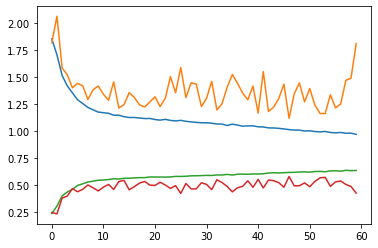

In [13]:
plt.plot(hist)

In [14]:
best_acc

0.5801185348938251